In [2]:
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np
import pandas as pd
import json
import os
import my_utils

In [3]:
DPI=300 # 300

In [4]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")

## Throughput

In [5]:
def get_throughput_paths_from_dir(directory: str) -> pd.DataFrame:
    result_json = {}
    # Assuming logs_directory is defined elsewhere in your code
    if not os.path.exists(os.path.join(logs_directory, directory, "result.json")):
        print(f"File {os.path.join(logs_directory, directory, 'result.json')} does not exist")
        return pd.DataFrame(columns=["nb_paths", "throughput", "implementation"])
    with open(os.path.join(logs_directory, directory, "result.json")) as f:
        result_json = json.load(f)
    
    df = pd.DataFrame(columns=["nb_paths", "throughput", "implementation"])
    data_to_append = []
    
    for measurement in result_json["measurements"]:
        for measurement_entry in measurement:
            if measurement_entry["name"] == "throughput":
                throughput_runs = measurement_entry["details"]
                filesize = measurement_entry["nb_paths"]
                implementation = measurement_entry["implementation"]
                
                for throughput in throughput_runs:
                    data_to_append.append({"nb_paths": filesize, "throughput": throughput, "implementation": implementation})
    df = pd.concat([df, pd.DataFrame(data_to_append)], ignore_index=True)
    return df

def get_throughput_nb_paths(directories: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["nb_paths", "throughput", "implementation"])
    for directory in directories:
        df_dir = get_throughput_paths_from_dir(directory)
        df = pd.concat([df, df_dir], ignore_index=True)
    df["nb_paths"] = df["nb_paths"].astype(int)
    df["throughput"] = df["throughput"].astype(float)
    return df

In [6]:
throughput_df = get_throughput_nb_paths(["logs_2024-05-23T10:47:38", "logs_2024-05-23T15:10:07"])

In [7]:
def plot_throughput(ax: plt.Axes, df: pd.DataFrame):
    """Plots the goodput data in a DataFrame as error bars."""
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    df["throughput"] = df["throughput"] / 1024 # Convert to Gbps
    fmts = ['*', 'p', 'h', 'H', 'd', '*', 'x', '+', '.']
    colors = [my_utils.get_color_for_impl(impl) for impl in implementations]
    all_nb_paths = list(df["nb_paths"].unique())
    all_nb_paths.sort()
    all_nb_paths = np.array(all_nb_paths)
    next_index = 0
    max_observed = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        y_data, yerr_data = [], []
        for nb_paths in all_nb_paths:
            throughput_values = df_impl[df_impl["nb_paths"] == nb_paths]["throughput"]
            throughput_values = throughput_values.to_numpy()
            if len(throughput_values) > 0:
                mean_value = np.mean(throughput_values)
                std_dev = np.std(throughput_values)
                y_data.append(mean_value)
                yerr_data.append(std_dev)
                max_observed = max(max_observed, mean_value + std_dev)
            else:
                y_data.append(0)
                yerr_data.append(0)
        fmt = fmts[next_index]
        ax.errorbar(
            all_nb_paths, y_data, yerr_data, linestyle='--', linewidth=1,
            capsize=2, elinewidth=1, fmt=fmt, color=colors[next_index], label=implementation)
        next_index += 1
    
    ax.set_xticks(all_nb_paths, all_nb_paths)
    ax.set_xlabel("Number of paths")
    ax.set_ylabel("Throughput [Gbps]")
    ax.grid(which='major', color='black', linewidth=.4, alpha=0.2, linestyle="dashed")  # Show the major grid
    ax.set_ylim(0)
    ax.legend(
        edgecolor='black', fancybox=False, shadow=False, framealpha=1,
    )
    ax.tick_params(axis='x', which='minor', bottom=False)  # Disable the minor ticks on the x-axis

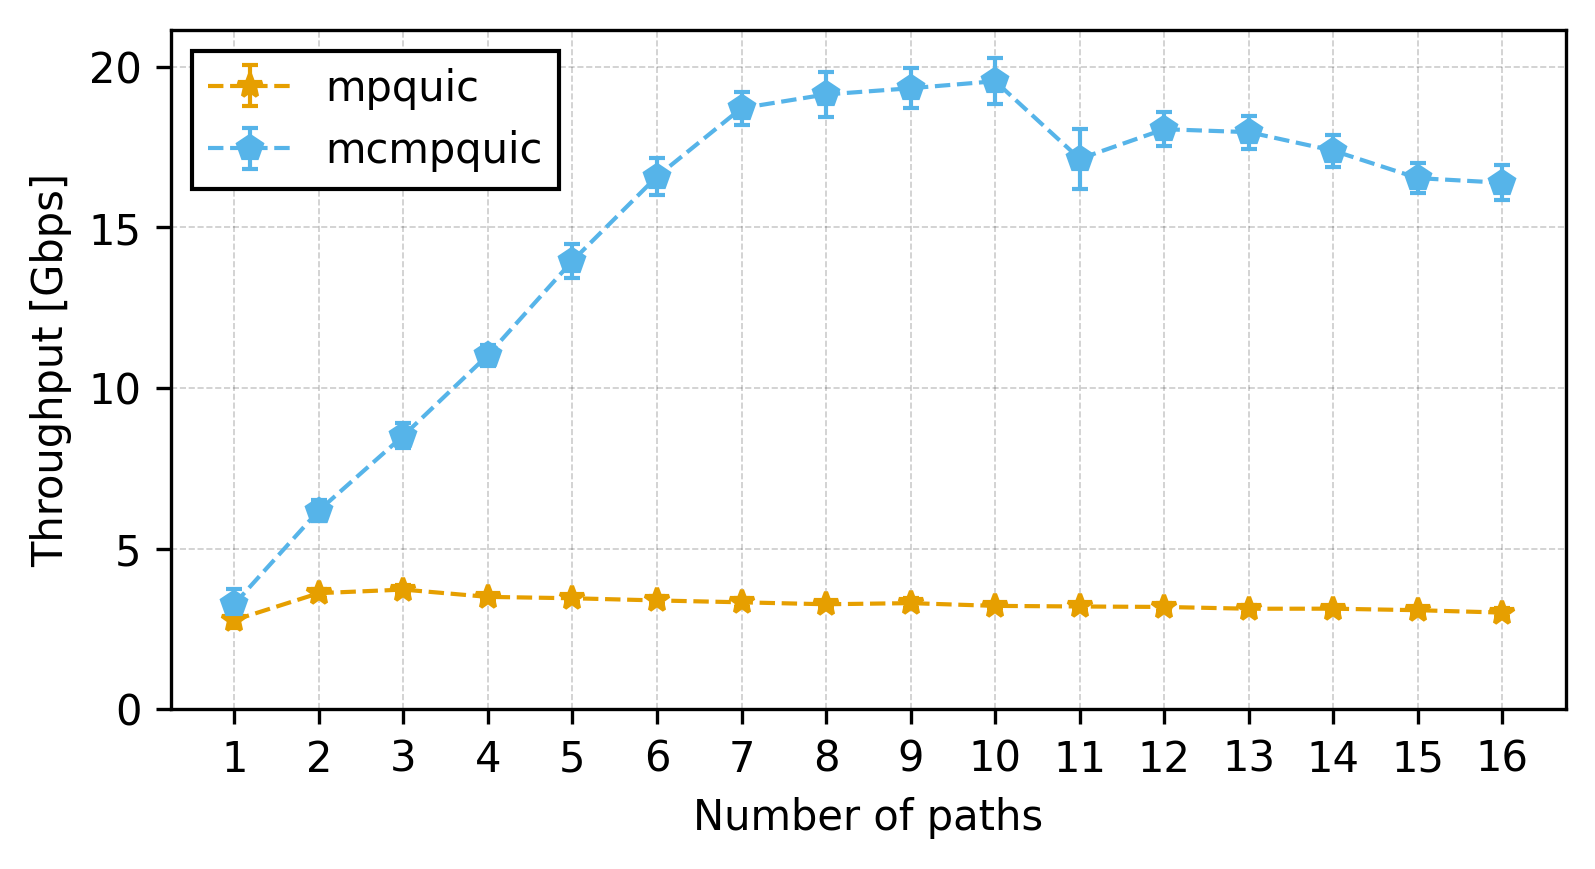

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 3), dpi=DPI)
#fig.suptitle("Throughput per number of paths")
plot_throughput(ax, throughput_df.copy())
#ax.set_title("Throughput of the differ ent implementations on the cloudlab testbed")
#fig.text(.5, .01, "For each implementation we repeat the experiment 10 times and each run lasts 20 seconds", ha='center')
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_20s.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_20s.svg"), format="svg", bbox_inches="tight")
plt.show()

In [11]:
cpu_aff_df = get_throughput_nb_paths(["logs_2024-05-25T13:26:46"])
cpu_aff_df["implementation"] = "mcmpquic-aff"
rfs_df = get_throughput_nb_paths(["logs_2024-05-21T21:31:51"])
rfs_df["implementation"] = "mcmpquic-rfs"
custom_df = throughput_df.loc[throughput_df["implementation"] == "mcmpquic"]
with_optimizations_df = pd.concat([custom_df, cpu_aff_df, rfs_df], ignore_index=True)

File ../logs/logs_2024-05-21T21:31:51/result.json does not exist


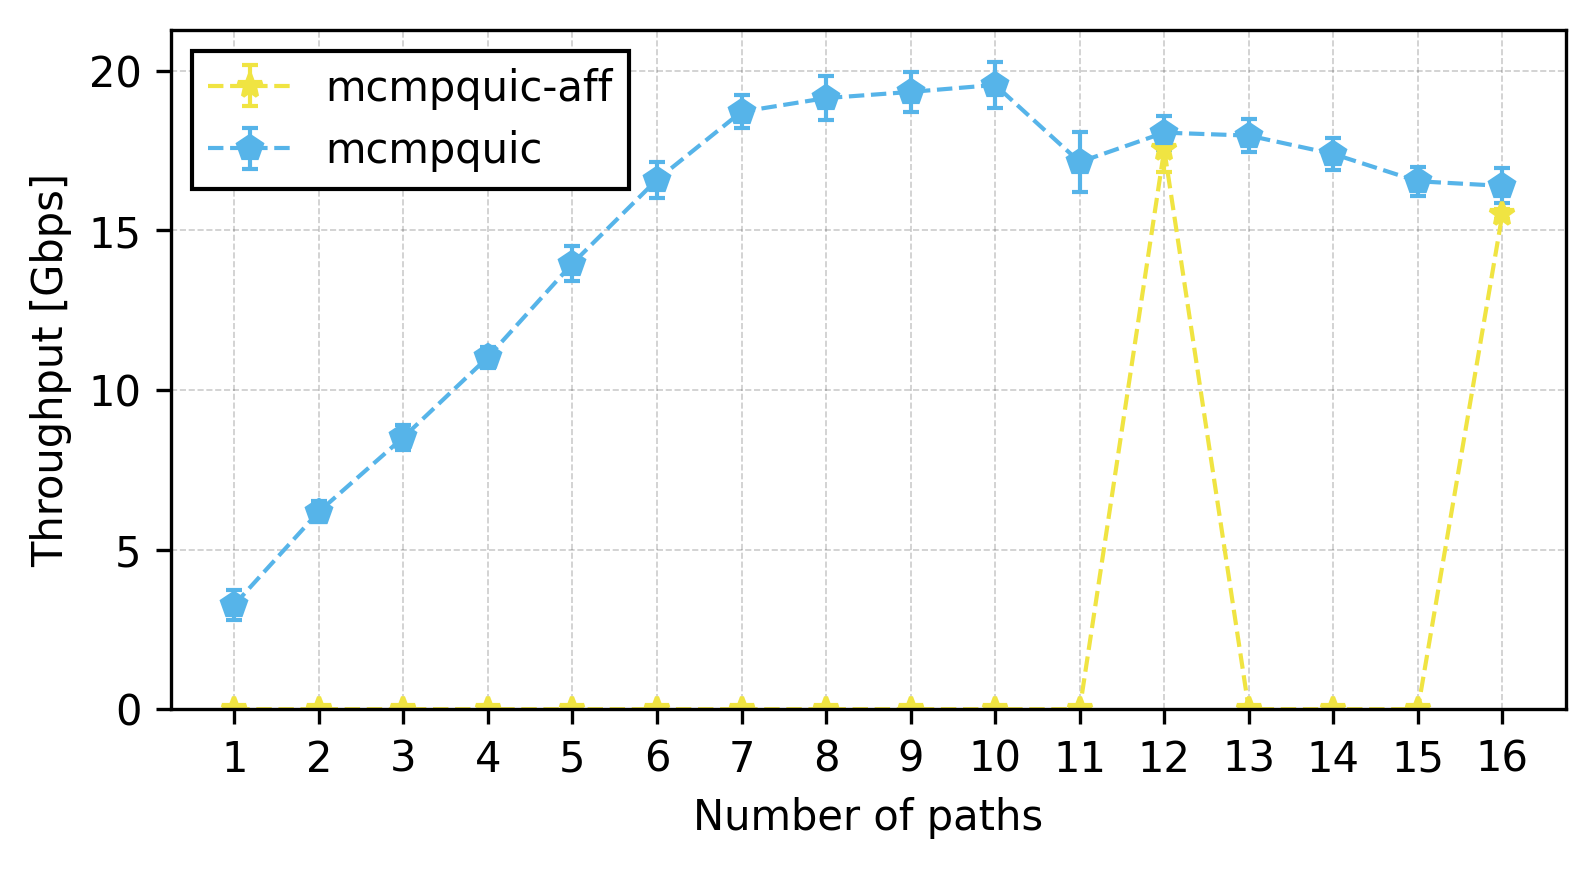

In [12]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 3), dpi=DPI)
#fig.suptitle("Throughput per number of paths")
plot_throughput(ax, with_optimizations_df.copy())
#ax.set_title("Throughput of the differ ent implementations on the cloudlab testbed")
#fig.text(.5, .01, "For each implementation we repeat the experiment 10 times and each run lasts 20 seconds", ha='center')
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_optimizations_20s.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join(plots_directory, "throughput_nb_paths_optimizations_20s.svg"), format="svg", bbox_inches="tight")
plt.show()